# Anomaly Detection

Anomaly Detection is the process of identifying data points that significantly deviate from the expected pattern in a dataset. These anomalies (or outliers) may indicate errors, fraud, faults, or unusual events in various domains like predictive maintenance, cybersecurity, and finance.

In [1]:
import pandas as pd
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sn

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Code

/content/drive/MyDrive/Code


In [4]:
# Load Data
df = pd.read_csv("pre-processed_file.csv")
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
0,2020-04-18 00:00:01,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,2020-04-18 00:00:13,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2,2020-04-18 00:00:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
3,2020-04-18 00:00:36,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2020-04-18 00:00:49,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59445 entries, 0 to 59444
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        59445 non-null  object 
 1   TP2              59445 non-null  float64
 2   TP3              59445 non-null  float64
 3   H1               59445 non-null  float64
 4   DV_pressure      59445 non-null  float64
 5   Reservoirs       59445 non-null  float64
 6   Oil_temperature  59445 non-null  float64
 7   Motor_current    59445 non-null  float64
 8   COMP             59445 non-null  float64
 9   DV_eletric       59445 non-null  float64
 10  Towers           59445 non-null  float64
 11  MPG              59445 non-null  float64
 12  LPS              59445 non-null  float64
 13  Pressure_switch  59445 non-null  float64
 14  Oil_level        59445 non-null  float64
 15  Caudal_impulses  59445 non-null  float64
 16  status           59445 non-null  int64  
dtypes: float64(1

#Simple Moving Average(SMA):

SMA is a basic statistical method used for time-series anomaly detection. It calculates the average of a fixed window of past values to smooth fluctuations and detect deviations (anomalies).

How SMA Helps in Anomaly Detection?

Compute SMA for a given window size (e.g., last 5 values).

Compare actual values with the moving average.

Identify anomalies when values deviate significantly from SMA (e.g., exceeding a threshold).

Steps for SMA-Based Anomaly Detection

Choose a window size (e.g., 5 or 10).

Compute SMA using past values.

Define an anomaly threshold (e.g., values exceeding ±2 standard deviations from SMA).

Mark values that deviate as anomalies.

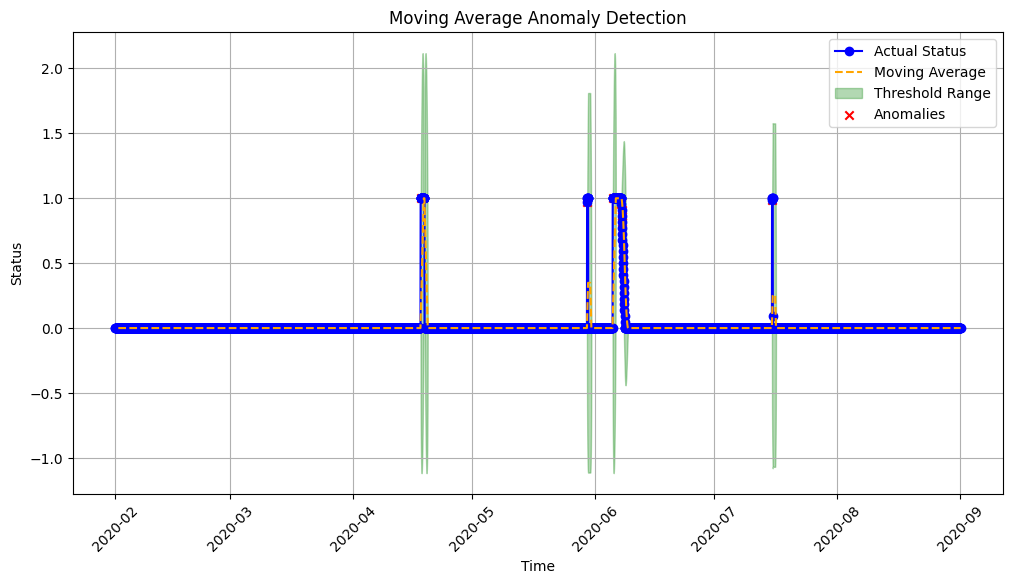

Detected Anomalies:
                       status  upper_bound  lower_bound
timestamp                                              
2020-04-18 00:00:00  1.000000     0.720820    -0.620820
2020-04-19 00:00:00  0.000000     1.620820     0.279180
2020-05-29 23:00:00  0.973118     0.701444    -0.604132
2020-06-05 10:00:00  1.000000     0.720820    -0.620820
2020-06-07 15:00:00  0.954545     1.028219     0.967235
2020-06-07 16:00:00  0.909091     1.059913     0.926451
2020-06-07 17:00:00  0.863636     1.095634     0.877093
2020-06-07 18:00:00  0.818182     1.133693     0.820853
2020-07-15 14:00:00  0.989130     0.712985    -0.614072


In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])  # Convert timestamp to datetime
df.set_index("timestamp", inplace=True)  # Set timestamp as index
df = df.sort_index()  # Ensure data is sorted

# Step 2: Resample Data (Optional, use if timestamps are irregular)
df = df.resample("h").mean()  # Resample to hourly intervals
df = df.interpolate()  # Fill missing values

# Step 3: Compute Moving Average & Standard Deviation
window_size = 20  # Define window for moving average
df["rolling_mean"] = df["status"].rolling(window=window_size).mean()
df["rolling_std"] = df["status"].rolling(window=window_size).std()

# Step 4: Define Upper and Lower Bound for Anomaly Detection
threshold = 3  # Defines how far values can deviate
df["upper_bound"] = df["rolling_mean"] + threshold * df["rolling_std"]
df["lower_bound"] = df["rolling_mean"] - threshold * df["rolling_std"]

# Step 5: Detect Anomalies
df["anomaly"] = (df["status"] > df["upper_bound"]) | (df["status"] < df["lower_bound"])

# Step 6: Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["status"], label="Actual Status", color="blue", marker="o")
plt.plot(df.index, df["rolling_mean"], label="Moving Average", color="orange", linestyle="dashed")
plt.fill_between(df.index, df["lower_bound"], df["upper_bound"], color="green", alpha=0.3, label="Threshold Range")
plt.scatter(df.index[df["anomaly"]], df["status"][df["anomaly"]], color="red", label="Anomalies", marker="x")
plt.xlabel("Time")
plt.ylabel("Status")
plt.title("Moving Average Anomaly Detection")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Step 7: Print Anomalies
print("Detected Anomalies:")
print(df[df["anomaly"]][["status", "upper_bound", "lower_bound"]])


This graph represents Moving Average Anomaly Detection with a dynamic threshold. Here's how to interpret it:

Actual Status (Blue Line with Dots):

Represents the actual observed values over time.

Most of the values remain at 0, but spikes (1) occur at specific timestamps.

Moving Average (Orange Dashed Line):

This is the smoothed version of the actual values using a moving average with a window size of 20.

It helps in detecting trends and reducing noise.

Threshold Range (Green Shaded Area):

Represents the dynamic threshold calculated using the rolling mean and standard deviation.

The height of the green bars indicates the allowable deviation from the moving average.

Anomalies (Red X Marks):

Points that exceed the dynamic threshold range are marked as anomalies.
These indicate unexpected deviations from the normal trend.

Observations:

The spikes in the actual status correspond to points where anomalies are detected.

The moving average closely follows the actual values but smooths out minor fluctuations.

The threshold range adapts to the variations in the data, making the detection dynamic instead of static.

In [7]:
# Load Data
df_l = pd.read_csv("pre-processed_file.csv")
df_l.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
0,2020-04-18 00:00:01,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,2020-04-18 00:00:13,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2,2020-04-18 00:00:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
3,2020-04-18 00:00:36,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2020-04-18 00:00:49,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1


In [8]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59445 entries, 0 to 59444
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        59445 non-null  object 
 1   TP2              59445 non-null  float64
 2   TP3              59445 non-null  float64
 3   H1               59445 non-null  float64
 4   DV_pressure      59445 non-null  float64
 5   Reservoirs       59445 non-null  float64
 6   Oil_temperature  59445 non-null  float64
 7   Motor_current    59445 non-null  float64
 8   COMP             59445 non-null  float64
 9   DV_eletric       59445 non-null  float64
 10  Towers           59445 non-null  float64
 11  MPG              59445 non-null  float64
 12  LPS              59445 non-null  float64
 13  Pressure_switch  59445 non-null  float64
 14  Oil_level        59445 non-null  float64
 15  Caudal_impulses  59445 non-null  float64
 16  status           59445 non-null  int64  
dtypes: float64(1

In [9]:
df_l["timestamp"] = pd.to_datetime(df_l["timestamp"])  # Convert timestamp to datetime
df_l.set_index("timestamp", inplace=True)  # Set timestamp as index

In [10]:
df_l.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
timestamp,,,,,,,,,,,,,,,,
2020-04-18 00:00:01,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2020-04-18 00:00:13,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2020-04-18 00:00:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2020-04-18 00:00:36,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-04-18 00:00:49,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1


#Long Short-Term Memory (LSTM):

LSTM (Long Short-Term Memory) networks are a type of recurrent neural network (RNN) used for sequence-based anomaly detection, particularly in time-series data. They are effective because they can capture long-term dependencies and patterns in sequential data.

How LSTM Works for Anomaly Detection:

Training on Normal Data: The LSTM model is typically trained on normal (non-anomalous) time-series data, learning normal patterns and behaviors.

Reconstruction or Prediction: It can either:

Reconstruct Input: Use an autoencoder architecture where the LSTM encodes and decodes the input, and high reconstruction error indicates anomalies.

Forecast Future Values: Predict the next time step, and large deviations between actual and predicted values suggest anomalies.

Anomaly Scoring: A threshold is set on the reconstruction or prediction error to classify anomalies.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.1177 - val_loss: 0.0023
Epoch 2/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 8.2145e-04 - val_loss: 4.7345e-04
Epoch 4/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.2640e-04 - val_loss: 3.3156e-04
Epoch 5/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 2.8604e-04 - val_loss: 1.3895e-04
Epoch 6/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1.5895e-04 - val_loss: 1.3685e-04
Epoch 7/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.1086e-04 - val_loss: 1.0622e-04
Epoch 8/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9.9743e-05 - val_loss: 8.3416e-05
Epoch 9/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 1.0313e-04 - val_loss: 1.1678e-04
Epoch 10/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 8.5875e-05 - val_loss: 7.2587e-05
Epoch 11/50
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 2

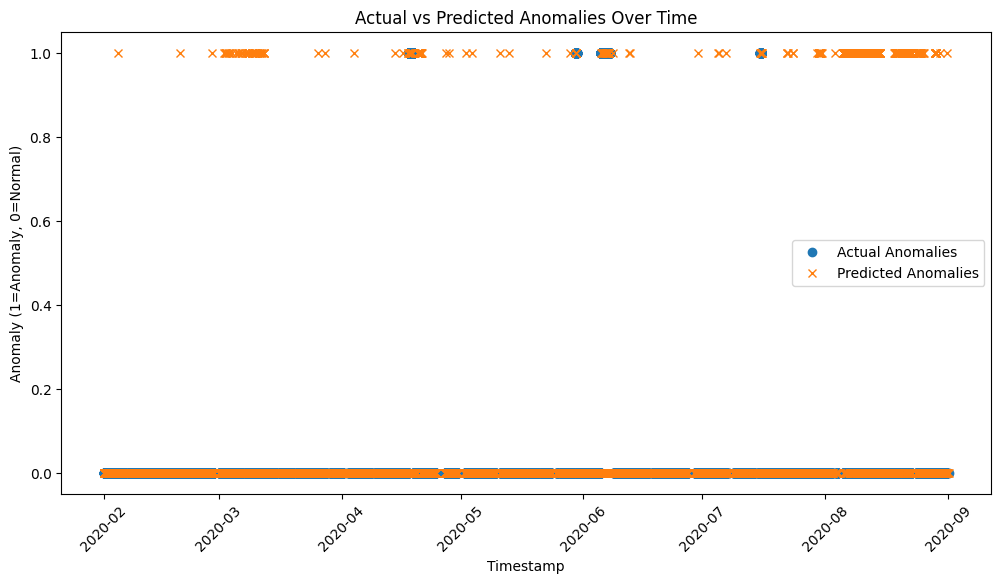

In [11]:
# Drop missing values
df_l.dropna(inplace=True)

# Feature Selection (Remove 'status' from features)
X = df_l.drop(columns=['status'])
y = df_l['status']  # Target labels

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split Dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Extract corresponding timestamps for test data
test_timestamps = df_l.loc[y_test.index].index

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM Autoencoder
model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(1),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Predict on Test Data
X_test_pred = model.predict(X_test)

# Calculate Reconstruction Error (MSE)
mse = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

# Convert y_test to NumPy for processing
y_test = y_test.to_numpy()

# Determine Anomaly Threshold (Using 95th percentile)
threshold = np.percentile(mse, 95)

# Anomaly Predictions (1 = Anomaly, 0 = Normal)
y_pred = (mse > threshold).astype(int)

# Save y_test, y_pred with timestamps to CSV
results_df = pd.DataFrame({'Timestamp': test_timestamps, 'Actual': y_test, 'Predicted': y_pred})
results_df.to_csv("y_test_vs_y_pred.csv", index=False)

# Plot Actual vs Predicted Anomalies against Timestamp
plt.figure(figsize=(12, 6))
plt.plot(test_timestamps, y_test, label="Actual Anomalies", marker='o', linestyle="")
plt.plot(test_timestamps, y_pred, label="Predicted Anomalies", marker='x', linestyle="")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly (1=Anomaly, 0=Normal)")
plt.xticks(rotation=45)
plt.legend()
plt.title("Actual vs Predicted Anomalies Over Time")
plt.show()


Interpretation of the Actual vs Predicted Anomalies Graph

X-Axis (Timestamp):

Represents the timeline from February 2020 to September 2020.

The data points are spaced across time, indicating when each instance was recorded.

Y-Axis (Anomaly Classification):

0 (Normal) → Data points at the bottom (near 0).

1 (Anomaly) → Data points at the top (near 1).

Legend & Markers:

Blue dots → Actual anomalies (labeled from y_test).

Orange Xs → Predicted anomalies (from y_pred).

If a blue dot and an orange X overlap, it means the model correctly detected the anomaly.

📌 Key Observations:

Model's Predictions Seem to Align Well with Actual Anomalies.

The orange Xs (predictions) are mostly in the same locations as blue dots (actual anomalies).

This suggests that the model has a decent anomaly detection performance.

Some False Positives & False Negatives May Exist.

If there are orange Xs without blue dots, the model falsely predicted an anomaly (false positive).

If there are blue dots without orange Xs, the model missed an anomaly (false negative).

Anomalies are Spread Throughout the Time Period.

The anomalies appear scattered across different months, showing that faults or failures occurred at different times.

In [ ]:
# Create a DataFrame with timestamps, actual values, and predicted anomalies
results_df = pd.DataFrame({'Timestamp': test_timestamps, 'Actual': y_test, 'Predicted': y_pred})

# Save to CSV file
results_df.to_csv("y_test_vs_y_pred_with_timestamps.csv", index=False)

print("Saved results to 'y_test_vs_y_pred_with_timestamps.csv'")

Saved results to 'y_test_vs_y_pred_with_timestamps.csv'
